In [4]:
# ============================================================================
# CLUSTERING ANALYSIS - KMeans on PCA-Reduced Features (ATP Main Tour Only)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ Libraries imported successfully")

# ============================================================================
# STEP 1: Load Engineered Data & Filter to ATP Main Tour
# ============================================================================

# This is the same file used in modeling_and_evaluation.ipynb

df = pd.read_csv('../data/processed/matches_with_engineered_features.csv')
print(f"Shape before ATP filter: {df.shape}")

# Keep only main ATP matches (Qualifying_match == 0)
df = df[df['Qualifying_match'] == 0].copy()
print(f"Shape after ATP filter (ATP main only): {df.shape}")

# Columns we do NOT want in the feature matrix for clustering
target_col = 'player1_won'
drop_cols = ['player1_won', 'Qualifying_match', 'tourney_date']  # tourney_date is temporal, we don't want time to dominate clusters



✓ Libraries imported successfully
Shape before ATP filter: (161807, 124)
Shape after ATP filter (ATP main only): (42356, 124)


Number of original features used for clustering: 121
PCA components used for clustering: 40
Total variance explained by these PCs: 82.69%

Clustering metrics by K:
 k silhouette calinski_harabasz davies_bouldin
 2     0.8134             508.0         0.9681
 3     0.0610            2244.1         3.3638
 4     0.0710            2178.4         3.0111
 5     0.0735            2225.5         2.6918
 6     0.0670            2194.7         2.5384
 7     0.0764            2081.4         2.4822
 8     0.0909            1972.4         2.2188


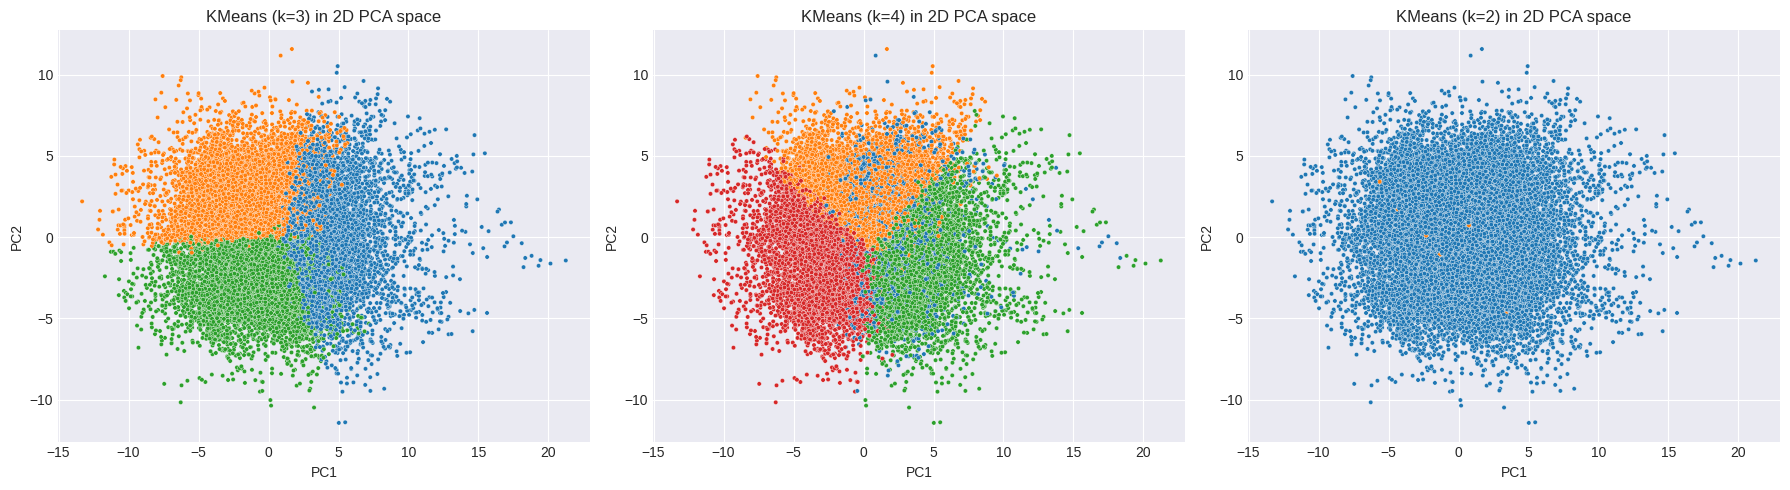

In [5]:
# ============================================================================
# STEP 2: Build Feature Matrix, Scale, and Apply PCA
# ============================================================================

feature_cols = df.columns.drop(drop_cols)
X = df[feature_cols].values

print(f"Number of original features used for clustering: {X.shape[1]}")

# 1) Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2) PCA for dimensionality reduction
# Option A: fixed max components (capped at 40)
max_components = min(40, X_scaled.shape[1])
pca = PCA(n_components=max_components, random_state=42)
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_.sum()
print(f"PCA components used for clustering: {X_pca.shape[1]}")
print(f"Total variance explained by these PCs: {explained:.2%}")

# If you prefer variance-based PCA instead, comment the block above and use:
# pca = PCA(n_components=0.90, random_state=42)  # keep 90% of variance
# X_pca = pca.fit_transform(X_scaled)
# print(f"PCA components used for clustering: {X_pca.shape[1]}")
# print(f"Total variance explained by these PCs: {pca.explained_variance_ratio_.sum():.2%}")

# ============================================================================
# STEP 3: KMeans++ for Multiple K and Clustering Metrics
# ============================================================================

k_values = [2, 3, 4, 5, 6, 7, 8]
results = []

for k in k_values:
    km = KMeans(
        n_clusters=k,
        init='k-means++',   # KMeans++ initialization
        n_init='auto',
        random_state=42
    )
    labels = km.fit_predict(X_pca)

    sil = silhouette_score(X_pca, labels)
    ch  = calinski_harabasz_score(X_pca, labels)
    db  = davies_bouldin_score(X_pca, labels)

    results.append({
        'k': k,
        'silhouette': sil,
        'calinski_harabasz': ch,
        'davies_bouldin': db
    })

metrics_df = pd.DataFrame(results)
print("\nClustering metrics by K:")
print(metrics_df.to_string(index=False, formatters={
    'silhouette': lambda v: f"{v:.4f}",
    'calinski_harabasz': lambda v: f"{v:.1f}",
    'davies_bouldin': lambda v: f"{v:.4f}"
}))

# ============================================================================
# STEP 4: Visualize Clusters in 2D PCA Space for Selected K Values
# ============================================================================

# First two PCs for plotting
X_pca_2d = X_pca[:, :2]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_ks = [3, 4, 2]  # you can change this list based on metrics_df

for ax, k in zip(axes, plot_ks):
    km = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init='auto',
        random_state=42
    )
    labels = km.fit_predict(X_pca)

    sns.scatterplot(
        x=X_pca_2d[:, 0],
        y=X_pca_2d[:, 1],
        hue=labels,
        palette='tab10',
        s=10,
        ax=ax,
        legend=False
    )
    ax.set_title(f'KMeans (k={k}) in 2D PCA space')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

plt.tight_layout()
plt.show()




Cluster counts:
cluster_k
0     7404
1    17391
2    17561
Name: count, dtype: int64

Cluster profiles (mean values for selected features):
           rank_difference  player1_career_win_rate  player2_career_win_rate  career_win_rate_diff  recent_form_diff  player1_career_matches  player2_career_matches  surface_Clay  surface_Grass  surface_Hard
cluster_k                                                                                                                                                                                                      
0                   -0.842                    0.618                    0.603                 0.015             0.012                 347.673                 329.636         0.046          0.021         0.934
1                  -72.174                    0.546                    0.411                 0.135             0.140                 175.319                  78.661         0.376          0.131         0.491
2                   77.063 

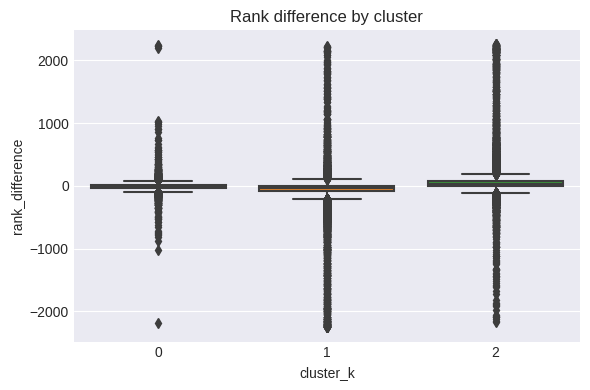


✓ Clustering analysis complete. Inspect metrics_df, plots, and cluster_profile for interpretation.


In [13]:
# ============================================================================
# STEP 5: Choose a K, Refit, and Analyze Cluster Profiles in Original Features
# ============================================================================

# Manually set this after inspecting metrics_df and the plots above
k_best = 3  # <-- change this if a different K looks better

km_final = KMeans(
    n_clusters=k_best,
    init='k-means++',
    n_init='auto',
    random_state=42
)
final_labels = km_final.fit_predict(X_pca)

# Attach cluster labels back to original dataframe
df_clusters = df.copy()
df_clusters['cluster_k'] = final_labels

print("\nCluster counts:")
print(df_clusters['cluster_k'].value_counts().sort_index())

# Example: inspect mean values of key features per cluster
key_features = [
    'rank_difference',
    'player1_career_win_rate',
    'player2_career_win_rate',
    'career_win_rate_diff',
    'recent_form_diff',
    'player1_career_matches',
    'player2_career_matches',
    'surface_Clay',
    'surface_Grass',
    'surface_Hard'
]

available_keys = [f for f in key_features if f in df_clusters.columns]

cluster_profile = df_clusters.groupby('cluster_k')[available_keys].mean().round(3)
print("\nCluster profiles (mean values for selected features):")
print(cluster_profile.to_string())

# Example visualization: rank_difference by cluster
if 'rank_difference' in df_clusters.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_clusters, x='cluster_k', y='rank_difference')
    plt.title('Rank difference by cluster')
    plt.tight_layout()
    plt.show()

print("\n✓ Clustering analysis complete. Inspect metrics_df, plots, and cluster_profile for interpretation.")


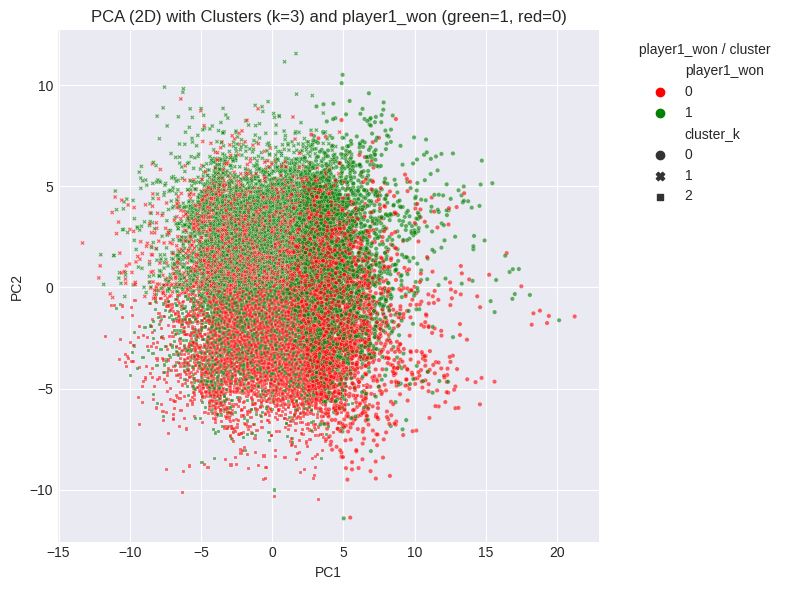


player1_won rate per cluster:
cluster_k
0    0.513
1    0.635
2    0.358
Name: player1_won, dtype: float64


In [14]:
# ============================================================================
# STEP 6: Visualize Clusters with player1_won (Green = Win, Red = Loss)
# ============================================================================

# Add the 2D PCA coords to df_clusters so we can plot with seaborn
X_pca_2d = X_pca[:, :2]          # same order as df
df_clusters['PC1'] = X_pca_2d[:, 0]
df_clusters['PC2'] = X_pca_2d[:, 1]

# Quick sanity: check that player1_won is still present
assert 'player1_won' in df_clusters.columns, "player1_won column missing"

# Color map: 0 = red (loss), 1 = green (win)
label_palette = {0: 'red', 1: 'green'}

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_clusters,
    x='PC1',
    y='PC2',
    hue='player1_won',
    style='cluster_k',             # different marker style per cluster
    palette=label_palette,
    s=10,
    alpha=0.6
)
plt.title(f'PCA (2D) with Clusters (k={k_best}) and player1_won (green=1, red=0)')
plt.legend(title='player1_won / cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Also print win rate per cluster for a numeric summary
print("\nplayer1_won rate per cluster:")
print(df_clusters.groupby('cluster_k')['player1_won'].mean().round(3))